# Q2
We are tasked with implementing a model called "CNN-MLP" proposed by the authors of the 2020 paper called "Remote sensing image scene classification using CNN-MLP with data augmentation" which aims to improve classification accuracy on VHR imagery. In this assignment we will use one of the 3 used publicly-available datasets used in the paper called "UC-Merced" dataset. We expand our training dataset via data augmentation and modify the pre-trained Xception network to create the "CNN-MLP" model. Lastly we will evaluate the performance of the obtained model to verify the effectiveness of "CNN_MLP".

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import os
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import timm
from PIL import Image

In [13]:
def get_ucmerced_augmentations():
    """Return list of augmentation transforms and their names."""
    augmentation_transforms = [
        transforms.RandomRotation(degrees=(90,91)),           # 90° rotation
        transforms.RandomRotation(degrees=(180,181)),        # 180° rotation
        transforms.RandomRotation(degrees=(270,271)),        # 270° rotation
        transforms.RandomHorizontalFlip(p=1.0),              # Horizontal flip
        transforms.RandomVerticalFlip(p=1.0),                # Vertical flip
        transforms.RandomResizedCrop(299, scale=(0.8, 1.0)) # Zoom + scale
    ]
    
    augmentation_names = [
        "Original",
        "Rotate 90°",
        "Rotate 180°", 
        "Rotate 270°",
        "Horizontal Flip",
        "Vertical Flip",
        "Zoom 80-100%"
    ]
    return augmentation_transforms, augmentation_names


def apply_augmentations(image, augmentations):
    augmented_images = [image]
    for transform in augmentations:
        try:
            augmented_img = transform(image)
            augmented_img = augmented_img.resize(image.size, Image.BILINEAR)
            augmented_images.append(augmented_img)
        except Exception as e:
            print(f"Augmentation failed: {e}, using original")
            augmented_images.append(image)
    return augmented_images

In [14]:
def load_ucmerced_dataset(image_paths, labels, transform=None, augment=False):
    dataset = []
    augmentations, _ = get_ucmerced_augmentations() if augment else ([], [])
    
    for img_path, label in zip(image_paths, labels):
        image = Image.open(img_path).convert('RGB')
        
        images_to_add = [image]
        if augment:
            images_to_add = apply_augmentations(image, augmentations)
        
        for img in images_to_add:
            if transform:
                img = transform(img)
            dataset.append((img, label))
    
    return dataset

In [15]:
def show_augmented_samples(dataset, num_samples=1):
    """Display original and augmented samples with proper names"""
    print("\nShowing augmented samples...")
    
    aug_names = [
        "Original",
        "Rotate 90°", 
        "Rotate 180°",
        "Rotate 270°",
        "Horizontal Flip",
        "Vertical Flip",
        "Zoom 80-100%"
    ]
    
    fig, axes = plt.subplots(num_samples, 7, figsize=(21, 3*num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        orig_idx = i * 7
        
        for j in range(7):
            try:
                img, label = dataset[orig_idx + j]
                
                # Denormalize for display
                img = img.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                axes[i, j].imshow(img)
                axes[i, j].set_title(f'{aug_names[j]}', fontsize=10)
                axes[i, j].axis('off')
                
            except IndexError:
                axes[i, j].axis('off')
                axes[i, j].set_title('N/A', fontsize=10)
    
    plt.suptitle('Original and Augmented Images', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

In [16]:
class EnhancedMLP(nn.Module):
    def __init__(self, input_features, num_classes, hidden_size=74, dropout_rate=0.4):
        super(EnhancedMLP, self).__init__()
        
        self.input_features = input_features
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.batch_norm = nn.BatchNorm1d(input_features)
        self.fc1 = nn.Linear(input_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.batch_norm(x)
        
        # First layer with sigmoid activation
        x = self.fc1(x)
        x = torch.sigmoid(x)
        
        # Dropout for regularization
        x = self.dropout(x)
        
        # Output layer
        x = self.fc2(x)
        
        return x

In [17]:

class CNNMLP(nn.Module):

    def __init__(self, num_classes, feature_dim=2048, mlp_hidden_size=74, dropout_rate=0.4):
        super(CNNMLP, self).__init__()
        
        self.feature_extractor = timm.create_model('xception', pretrained=True, num_classes=0, global_pool='avg')
        self.feature_extractor.fc = nn.Identity()
        self.classifier = EnhancedMLP(
            input_features=feature_dim,
            num_classes=num_classes,
            hidden_size=mlp_hidden_size,
            dropout_rate=dropout_rate
        )
        
        self._freeze_feature_extractor()
    
    def _freeze_feature_extractor(self):
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
    
    def extract_features(self, x):
        with torch.no_grad():
            features = self.feature_extractor(x)
        return features
    
    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

In [ ]:
def create_cnn_mlp_trainer(model, num_classes, device='cuda' if torch.cuda.is_available() else 'cpu', opt="Adagrad"):
    model = model.to(device)
    
    if opt == "Adagrad":
        optimizer = optim.Adagrad(
            model.classifier.parameters(),
            lr=0.01
        )
    elif opt == "Adam":
        optimizer = optim.Adam(
            model.classifier.parameters(),
            lr=0.01,
            weight_decay=1e-4
        )
        
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    return {
        'model': model,
        'optimizer': optimizer,
        'criterion': criterion,
        'device': device,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }

def train_mlp_classifier(trainer, train_loader, epochs=50):
    print("Training MLP classifier...")
    trainer['model'].train()
    trainer['model'].classifier.train() 
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(trainer['device']), target.to(trainer['device'])
            
            trainer['optimizer'].zero_grad()
            
            with torch.no_grad():
                features = trainer['model'].extract_features(data)
            
            output = trainer['model'].classifier(features)
            loss = trainer['criterion'](output, target)
            loss.backward()
            trainer['optimizer'].step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_predictions / total_samples
        
        trainer['train_losses'].append(epoch_loss)
        trainer['train_accuracies'].append(epoch_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')
    
    return trainer

def test_model(trainer, test_loader):
    trainer['model'].eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(trainer['device']), target.to(trainer['device'])
            output = trainer['model'](data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    trainer['test_accuracies'].append(accuracy)
    
    return accuracy

def calculate_class_accuracy(trainer, data_loader):
    trainer['model'].eval()
    class_correct = {}
    class_total = {}
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(trainer['device']), target.to(trainer['device'])
            output = trainer['model'](data)
            _, predicted = torch.max(output, 1)
            
            for label, prediction in zip(target, predicted):
                label = label.item()
                if label not in class_correct:
                    class_correct[label] = 0
                    class_total[label] = 0
                
                class_total[label] += 1
                if label == prediction.item():
                    class_correct[label] += 1
    
    class_accuracy = {}
    for label in class_total:
        class_accuracy[label] = 100 * class_correct[label] / class_total[label]
    
    total_accuracy = 100 * sum(class_correct.values()) / sum(class_total.values())
    
    return class_accuracy, total_accuracy

def get_training_history(trainer):
    return {
        'train_losses': trainer['train_losses'],
        'train_accuracies': trainer['train_accuracies'],
        'test_accuracies': trainer['test_accuracies']
    }

In [19]:
def plot_training_history(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_losses'], label='Train Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracies'], label='Train Accuracy', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### 2-1 Download the dataset

In [20]:
data_dir = 'UCMerced_LandUse/Images'

class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

all_image_paths = []
all_labels = []

for cls_name in class_names:
    cls_dir = os.path.join(data_dir, cls_name)
    for img_path in glob.glob(os.path.join(cls_dir, "*.tif")):
        all_image_paths.append(img_path)
        all_labels.append(class_to_idx[cls_name])

print("Total images:", len(all_image_paths))


Total images: 2100


In [21]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels,
    train_size=0.8,
    stratify=all_labels,
    random_state=0
)


In [22]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = load_ucmerced_dataset(train_paths, train_labels, transform=transform, augment=True)
test_dataset  = load_ucmerced_dataset(test_paths, test_labels, transform=transform, augment=False)

print(len(train_dataset), len(test_dataset))


11760 420


In [23]:
batch_size = 200

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)


In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

model = CNNMLP(num_classes=len(class_names))
trainer = create_cnn_mlp_trainer(model, len(class_names), device)


Using device: cuda


C:\Users\a\AppData\Roaming\Python\Python311\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [25]:
trainer = train_mlp_classifier(trainer, train_loader, epochs=5)


Training MLP classifier with augmented data...
Epoch [1/5], Loss: 0.8459, Train Accuracy: 83.20%
Epoch [2/5], Loss: 0.3890, Train Accuracy: 94.04%
Epoch [3/5], Loss: 0.2853, Train Accuracy: 95.95%
Epoch [4/5], Loss: 0.2295, Train Accuracy: 96.84%
Epoch [5/5], Loss: 0.1911, Train Accuracy: 97.47%


In [26]:
accuracy = test_model(trainer, test_loader)
print("Test Accuracy:", accuracy)


Test Accuracy: 94.04761904761905


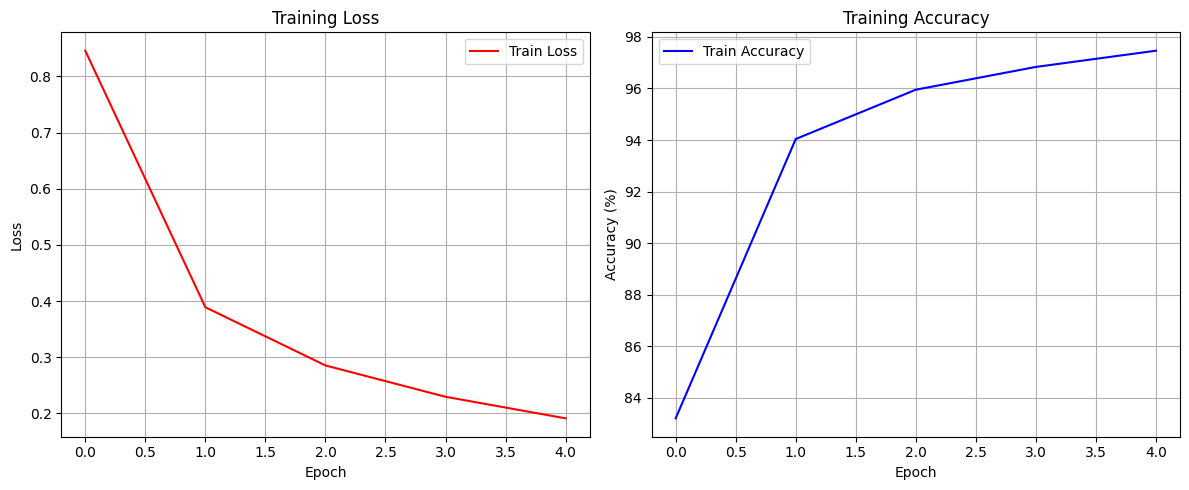

In [27]:
history = get_training_history(trainer)
plot_training_history(history)



Showing augmented samples...


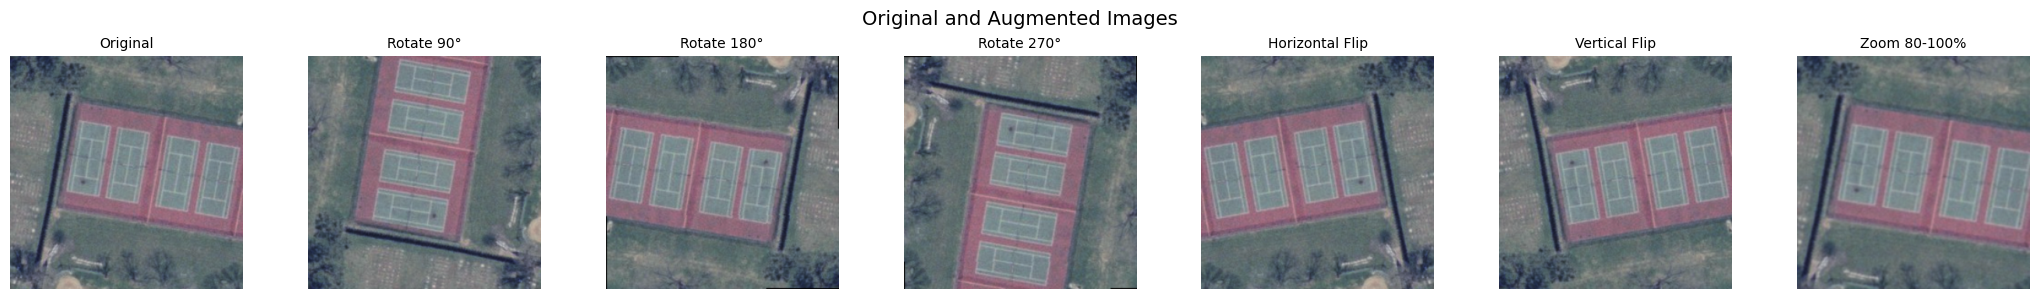

In [28]:
show_augmented_samples(train_dataset)


### Train without augmentation

In [29]:
train_dataset_no_aug = load_ucmerced_dataset(train_paths, train_labels, transform=transform, augment=False)
print(len(train_dataset_no_aug), len(test_dataset))

1680 420


In [30]:
train_loader_no_aug = DataLoader(
    train_dataset_no_aug,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)


In [31]:

model_no_aug = CNNMLP(num_classes=len(class_names))
trainer_no_aug = create_cnn_mlp_trainer(model_no_aug, len(class_names), device)
trainer_no_aug = train_mlp_classifier(trainer_no_aug, train_loader_no_aug, epochs=5)

Training MLP classifier with augmented data...
Epoch [1/5], Loss: 1.6863, Train Accuracy: 58.39%
Epoch [2/5], Loss: 0.8585, Train Accuracy: 87.26%
Epoch [3/5], Loss: 0.6346, Train Accuracy: 91.79%
Epoch [4/5], Loss: 0.5404, Train Accuracy: 94.58%
Epoch [5/5], Loss: 0.4569, Train Accuracy: 95.71%


In [32]:
accuracy_no_aug = test_model(trainer_no_aug, test_loader)
print("Test Accuracy:", accuracy_no_aug)

Test Accuracy: 92.14285714285714


### Train with adam instead of adagrad

In [35]:
model_adam = CNNMLP(num_classes=len(class_names))
trainer_adam = create_cnn_mlp_trainer(model_adam, len(class_names), device, opt="Adam")
trainer_adam = train_mlp_classifier(trainer_adam, train_loader, epochs=5)

C:\Users\a\AppData\Roaming\Python\Python311\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Training MLP classifier with augmented data...
Epoch [1/5], Loss: 0.6401, Train Accuracy: 84.21%
Epoch [2/5], Loss: 0.2029, Train Accuracy: 94.63%
Epoch [3/5], Loss: 0.1422, Train Accuracy: 96.10%
Epoch [4/5], Loss: 0.1245, Train Accuracy: 96.57%
Epoch [5/5], Loss: 0.0980, Train Accuracy: 97.36%


In [36]:
accuracy_adam = test_model(trainer_adam, test_loader)
print("Test Accuracy:", accuracy_adam)

Test Accuracy: 94.28571428571429


### Freeze last 10 convolutional layers and train again (fine tune)